In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    log_loss,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    confusion_matrix,
)
from tpot import TPOTClassifier
import matplotlib.pyplot as plt

In [10]:
# Load pd_train
pd_train = pd.read_parquet("data/training_class_2d.parquet")
pd_train["label"] = pd_train["Liver"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
# print(pd_train.shape)
pd_train.head()

,Smiles,Liver,smiles_len,Name,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,...,APC2D10_I_B,APC2D10_I_Si,APC2D10_I_X,APC2D10_B_B,APC2D10_B_Si,APC2D10_B_X,APC2D10_Si_Si,APC2D10_Si_X,APC2D10_X_X,label
0,S=C=Nc1c2c(ccc1)cccc2,Hepatotoxicity,21,AUTOGEN_Training_Group_PaDel_index_2d_10,0,0.1685,0.028392,22.5312,13.609551,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,c1(c(cc(cc1[N+](=O)[O-])[N+](=O)[O-])[N+](=O)[...,Hepatotoxicity,51,AUTOGEN_Training_Group_PaDel_index_2d_9,0,-0.9708,0.942453,31.8010,23.646758,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,c1(c(cc(cc1)[N+](=O)[O-])[N+](=O)[O-])O,Hepatotoxicity,39,AUTOGEN_Training_Group_PaDel_index_2d_4,0,-0.2385,0.056882,23.5986,15.311930,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,O(CCO)CC,Hepatotoxicity,8,AUTOGEN_Training_Group_PaDel_index_2d_12,0,-1.1950,1.428025,38.2306,25.692688,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,Oc1cc2c(cc1)cccc2,Hepatotoxicity,17,AUTOGEN_Training_Group_PaDel_index_2d_2,0,2.6223,6.876457,17.1721,23.765965,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [11]:
# Load pd_test
pd_test = pd.read_parquet("data/testing_class_2d.parquet")
pd_test["label"] = pd_test["Liver"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_test.shape)
pd_test.head()

(286, 17540)


,Smiles,Liver,Name,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,...,APC2D10_I_B,APC2D10_I_Si,APC2D10_I_X,APC2D10_B_B,APC2D10_B_Si,APC2D10_B_X,APC2D10_Si_Si,APC2D10_Si_X,APC2D10_X_X,label
0,C[C@@H](C(=O)N[C@@H](C)C(=O)NC1[C@H]2[C@@H]1CN...,Hepatotoxicity,AUTOGEN_Testing_Group_PaDel_index_2d_2,1,1.4897,2.219206,62.0266,31.280723,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,C=CCOC1=C(C=C(C=C1)CC(=O)O)Cl,Hepatotoxicity,AUTOGEN_Testing_Group_PaDel_index_2d_11,0,0.7974,0.635847,68.6706,35.947516,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,CCCN(CCC)C(=O)CC1=C(N=C2N1C=C(C=C2)Cl)C3=CC=C(...,Hepatotoxicity,AUTOGEN_Testing_Group_PaDel_index_2d_10,1,1.0072,1.014452,86.4498,40.957516,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,C1CC2=CC=CC=C2C(C3=CC=CC=C31)NCCCCCCC(=O)O,Hepatotoxicity,AUTOGEN_Testing_Group_PaDel_index_2d_6,1,2.0128,4.051364,86.9652,41.847516,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,C1=CC=C(C=C1)CN2C3=CC=CC=C3C(=N2)OCC(=O)O,Hepatotoxicity,AUTOGEN_Testing_Group_PaDel_index_2d_8,0,1.4819,2.196028,99.6746,46.427516,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [13]:
X_train = pd_train.drop(columns=["Liver", "Smiles", "Name", "label", "smiles_len"])
X_train = X_train.fillna(0)
X_train = X_train.replace([np.inf, -np.inf], 0)
y_train = pd_train["label"]

X_test = pd_test[X_train.columns]
X_test = X_test.fillna(0)
X_test = X_test.replace([np.inf, -np.inf], 0)
y_test = pd_test["label"]

# TPOT optimization

In [9]:
# Apply PCA
n_components = 100
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Set up TPOT with basic configuration
tpot = TPOTClassifier(
    generations=5,
    population_size=20,
    verbosity=2,
    scoring="roc_auc",  # AUC
    random_state=42,
    n_jobs=12,  # Use 4 cores
)

# Fit TPOT on the PCA-transformed data
tpot.fit(X_train_pca, y_train)

                                                                              
Generation 1 - Current best internal CV score: 0.6748181166819607
                                                                             
Generation 2 - Current best internal CV score: 0.6800423185694642
                                                                             
Generation 3 - Current best internal CV score: 0.6800423185694642
                                                                             
Generation 4 - Current best internal CV score: 0.6800423185694642
                                                                              
Generation 5 - Current best internal CV score: 0.6890685389101969
                                                                              
Best pipeline: GradientBoostingClassifier(GaussianNB(ZeroCount(input_matrix)), learning_rate=0.1, max_depth=4, max_features=0.55, min_samples_leaf=3, min_samples_split=9, n_estimators=100, subsample=

TPOTClassifier(generations=5, n_jobs=12, population_size=20, random_state=42,
               scoring='roc_auc', verbosity=2)

In [ ]:
# # Set up TPOT with basic configuration
# tpot = TPOTClassifier(
#     generations=5,
#     population_size=20,
#     verbosity=2,
#     scoring="roc_auc",  # AUC
#     random_state=42,
#     n_jobs=8,  # Use 8 cores
# )

# # Fit the model
# tpot.fit(X_train, y_train)

In [ ]:
# # Evaluate the best model found by TPOT
# y_pred = tpot.predict(X_test)
# y_pred_proba = tpot.predict_proba(X_test)[:, 1]

# # Print performance metrics
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Log Loss:", log_loss(y_test, y_pred_proba))
# print("AUC:", roc_auc_score(y_test, y_pred_proba))

Accuracy: 0.8146853146853147
Log Loss: 0.47206500243926136
AUC: 0.88771319178559


## Find best threshold

In [10]:
# Extract model name and parameters
best_pipeline = tpot.fitted_pipeline_
model_name = type(best_pipeline.steps[-1][1]).__name__  # Name of the final estimator
model_params = best_pipeline.steps[-1][1].get_params()  # Params of the final estimator

# Check if the model has predict_proba
if hasattr(best_pipeline, "predict_proba"):
    y_pred_proba = best_pipeline.predict_proba(X_test_pca)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
else:
    # Fallback to accuracy if predict_proba is unavailable
    y_pred_proba = best_pipeline.predict(X_test_pca)
    auc = accuracy_score(
        y_test, y_pred_proba
    )  # Substitute with accuracy if AUC can't be calculated

# Initialize variables to store the best threshold and performance metrics
best_threshold = 0.5
best_metrics = {
    "accuracy": 0,
    "precision": 0,
    "recall": 0,
    "sensitivity": 0,
    "specificity": 0,
    "f1": 0,
}

# Iterate over possible thresholds
for threshold in np.arange(0.0, 1.0, 0.01):
    # Binarize predictions based on the current threshold
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Calculate precision, recall, accuracy, sensitivity, and specificity
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # Same as sensitivity for positive class
    accuracy = accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = f1_score(y_test, y_pred)

    # Update the best threshold if Youden's J is higher than previous best
    if f1 > best_metrics["f1"]:
        best_threshold = threshold
        best_metrics = {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "sensitivity": sensitivity,
            "specificity": specificity,
            "f1": f1,
        }

# Append results to list
result = {
    "Best model": best_pipeline,
    "PCA Components": n_components,
    "Model Name": model_name,
    # "Parameters": model_params,
    "Best Threshold": best_threshold,
    "AUC": auc,
    **best_metrics,
}

result

c:\Users\predator\anaconda3\envs\dili-3.10\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\predator\anaconda3\envs\dili-3.10\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\predator\anaconda3\envs\dili-3.10\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\p

{'Best model': Pipeline(steps=[('zerocount', ZeroCount()),
                 ('stackingestimator',
                  StackingEstimator(estimator=GaussianNB())),
                 ('gradientboostingclassifier',
                  GradientBoostingClassifier(max_depth=4, max_features=0.55,
                                             min_samples_leaf=3,
                                             min_samples_split=9,
                                             random_state=42, subsample=0.8))]),
 'PCA Components': 100,
 'Model Name': 'GradientBoostingClassifier',
 'Best Threshold': 0.35000000000000003,
 'AUC': 0.8581970066132961,
 'accuracy': 0.8566433566433567,
 'precision': 0.8846153846153846,
 'recall': 0.9366515837104072,
 'sensitivity': 0.9366515837104072,
 'specificity': 0.5846153846153846,
 'f1': 0.9098901098901099}

# PCA optimization

In [2]:
# # Example data (replace with actual data)
# X = pd.DataFrame(
#     np.random.randn(1000, 1600), columns=[f"feature_{i}" for i in range(1600)]
# )
# y = np.random.randint(2, size=1000)

# # Split data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# # Dimensions for PCA
# dimensions = [10, 20, 50]
# tpot_results = []  # List to store results

In [ ]:
# List to store AUC scores for different PCA dimensions
# dimensions = range(100, 500, 100)  # Check PCA dimensions from 1 to 10
dimensions = [10, 20, 50, 100, 200, 300, 500, 800, 1000, 1200]
dimensions = [20, 50, 100]
# tpot_results = []  # List to store results

# Loop over different numbers of PCA components
for n_components in dimensions:
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Set up TPOT with basic configuration
    tpot = TPOTClassifier(
        generations=5,
        population_size=20,
        verbosity=2,
        scoring="roc_auc",  # AUC
        random_state=42,
        n_jobs=12,  # Use 4 cores
    )

    # Fit TPOT on the PCA-transformed data
    tpot.fit(X_train_pca, y_train)

    # Access the best pipeline directly after fitting
    best_pipeline = tpot.fitted_pipeline_

    # Check if the model has predict_proba
    if hasattr(best_pipeline, "predict_proba"):
        y_pred = best_pipeline.predict_proba(X_test_pca)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
    else:
        # Fallback to accuracy if predict_proba is unavailable
        y_pred = best_pipeline.predict(X_test_pca)
        auc = accuracy_score(
            y_test, y_pred
        )  # Substitute with accuracy if AUC can't be calculated

    y_pred = (y_pred > 0.5).astype(int)  # Binarize predictions for threshold of 0.5
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # Same as sensitivity for positive class

    # Calculate sensitivity and specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Extract model name and parameters
    model_name = type(
        best_pipeline.steps[-1][1]
    ).__name__  # Name of the final estimator
    model_params = best_pipeline.steps[-1][
        1
    ].get_params()  # Params of the final estimator

    # Append results to list
    result = {
        "Best model": best_pipeline,
        "PCA Components": n_components,
        "Model Name": model_name,
        "Parameters": model_params,
        "AUC": auc,
        "Precision": precision,
        "Recall": recall,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
    }
    tpot_results.append(result)

    print(result)

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]

In [15]:
# Convert results to DataFrame
tpot_df = pd.DataFrame(tpot_results)
tpot_df

,Best model,PCA Components,Model Name,Parameters,AUC,Precision,Recall,Sensitivity,Specificity
0,(KNeighborsClassifier(n_neighbors=34)),10,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.502541,0.771144,0.701357,0.701357,0.292308


In [ ]:
import pandas as pd
import joblib

# Save results using Joblib
joblib.dump(tpot_results, "models/tpot_results_2d.joblib")
print("Results saved to tpot_results_2d.joblib")

# # Optionally, load the results back
# loaded_results = joblib.load("models/tpot_results_2d.joblib")

# # Convert results to DataFrame
# tpot_df = pd.DataFrame(loaded_results)
# tpot_df

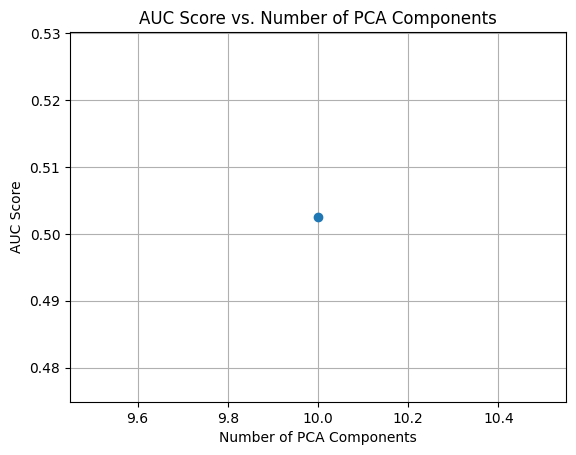

In [16]:
# Plot AUC scores against the number of PCA components
plt.plot(tpot_df["PCA Components"], tpot_df["AUC"], marker="o")
plt.xlabel("Number of PCA Components")
plt.ylabel("AUC Score")
plt.title("AUC Score vs. Number of PCA Components")
plt.grid()
plt.show()